Importiere `pyboard` und andere Module. Wichtig ist, dass sich die Datei [`pyboard.py`](https://github.com/micropython/micropython/blob/master/tools/pyboard.py) im selben Verzeichnis wie dieses Notebook befinden. 

In [2]:
import pyboard
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

pb = None

Öffne eine serielle Verbindung zum Microcontroller-Board. Wenn hier das Board nicht gefunden wird, kann man folgendes probieren:
- USB-Kabel ab- und wieder anstecken  
- Überprüfen, ob die richtige Schnittstelle angegeben ist

In [3]:
if pb is None:
    try:
        pb = pyboard.Pyboard("COM3")
    except pyboard.PyboardError as e:
        print(e)

Öffne Zugang zum REPL

In [4]:
pb.enter_raw_repl()

Definiere eine einfache Funktion, um ein Skript auf dem Board auszuführen. Die Funktion geht davon aus, dass das Board über `pb` anzusprechen ist.

In [5]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res    

Rufe das Skript auf, dass den Wärmebildsensor AMG8833 auf dem I2C-Bus detektiert und initialisiert. Der Sensor braucht etwas Zeit, daher die kurze Wartezeit nach der Initialisierung.

In [6]:
script = [
    'from robotling_lib.driver.amg88xx import AMG88XX',
    'import robotling_lib.platform.esp32.busio as busio',
    'import robotling_lib.platform.esp32.dio as dio',
    'power5V = dio.DigitalOut(16, value=True)',
    'i2c = busio.I2CBus(400000, 22, 23)',
    'amg = AMG88XX(i2c)',
]
_ = run_on_board(script, wait_s=0.4)

Software I2C bus frequency is 400.0 kHz
Scanning I2C bus ...
... 2 device(s) found ([96, 105])
[     amg88xx] GRID-Eye IR 8x8 thermal camera      (0.1.0.0): ok


Definiert die Hilfsfunktion `get_image()`, die ein neues Bild zurückliefert.

Die Funktion ruft erst das Skript auf, dass Daten vom Wärmebildsensor liest. Die Daten werden als 1D-Vektor mit 64 Temperaturwerten (in °Celsius) geliefert. Da die `pyboard`-Funktion einen String zurückgibt, wird dieser mittels einer `json`-Funktion in eine Liste umgewandelt. Anschließend wird der Vektor in ein 8x8 Pixel-Bild umgeformt, dann rotiert und geflippt, damit es richig herum angezeigt wird.

In [7]:
def get_image():
    script = [
        'img_raw = list(amg.pixels_64x1)',
        'print(img_raw)'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    return np.flip(np.transpose(np.reshape(raw, (8, 8))))

img = get_image()
print(img)

[[19 21 20 21 21 21 21 21]
 [21 20 20 20 21 21 22 23]
 [22 23 21 21 21 22 27 25]
 [22 25 22 21 21 22 26 26]
 [22 24 25 25 25 25 26 26]
 [21 22 24 26 25 26 25 26]
 [20 21 21 23 25 26 26 26]
 [20 21 21 21 23 24 25 26]]


Das aktuelle Wärmebild im Original (links) und geglättet (rechts):

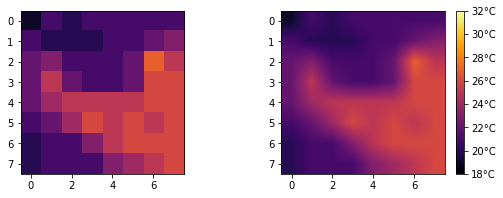

In [8]:
# Erstelle eine Abbildung mit zwei Unterfenstern
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

# Stelle das Wärmebild in den jeweiligen Unterfenstern dar
im1 = ax1.imshow(img, cmap='inferno', vmin=18, vmax=32)
im2 = ax2.imshow(img, cmap='inferno', vmin=18, vmax=32, interpolation="bilinear")

# Füge eine Farbskala hinzu
plt.colorbar(im1, format="%.0f°C")

Das folgende Skript liest den Sensor `nrepeats` Mal aus, skaliert die Werte auf den Bereich von `tmin` bis `tmax` °Celsius und zeigt es kontinuierlich an (wenn `smooth == True`, dann wird das Bild geglättet. Zum Anhalten der Animation auf den blauen Knopf drücken.

In [10]:
%matplotlib notebook

# Darstellungsparameter
nrepeats = 50
interpol = "bilinear"
tmin = 20
tmax = 34
cmap = "inferno" 

# Erstelle eine Abbildung mit einem Unterfenster
fig, (ax1) = plt.subplots(1, 1, figsize=(3,3))

# Erzeuge ein leeres Bild und zeige es zusammen mit der Farbskala an
img = np.zeros((8,8))
im = plt.imshow(img, cmap=cmap, vmin=tmin, vmax=tmax, interpolation=interpol)
plt.colorbar(format="%.0f°C")

# Die folgende Funktion lädt ein Bild vom Sensor und kopiert es in die Abbildung
def update1(i):
    img = get_image()
    im.set_array(img)
    return im, 

# Zeige die Abbildung als Animation
ani1 = FuncAnimation(plt.gcf(), update1, frames=range(nrepeats), interval=1, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [24]:
_ = run_on_board(['import robotling_lib.misc.blob as blob'])

Definiert eine Hilfsfunktion, die ein Wärmebild liest und mit Hilfe der Funktion `find_blobs`, die auf dem Board läuft, "Blobs" im Bild detektiert. 

<IPython.core.display.Javascript object>


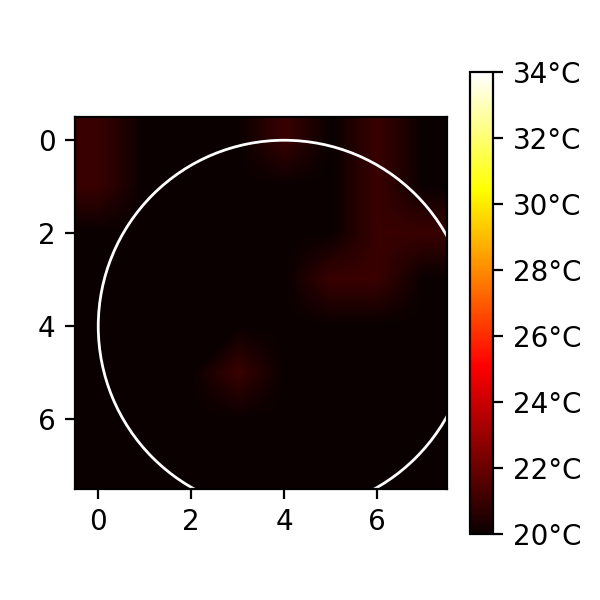

In [30]:
def get_image_blobs():
    script = [
        'img_raw = list(amg.pixels_64x1)',
        'print(img_raw)'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    img = np.flip(np.transpose(np.reshape(raw, (8, 8))))
    script = [
        'blob_list = blob.find_blobs_timed(img_raw, (8, 8))',
        'print(blob_list)'
    ]
    blobs = json.loads(run_on_board(script, no_print=True))
    return img, blobs

# Erstelle eine Abbildung mit einem Unterfenster
fig, ax1 = plt.subplots(1, 1, figsize=(3,3))
circ = Circle((4,4), radius=1, fill=False, ec="w")
ax1.add_patch(circ)
    
# Erzeuge ein leeres Bild und zeige es zusammen mit der Farbskala an
img = np.zeros((8,8))
im = plt.imshow(img, cmap=cmap, vmin=tmin, vmax=tmax, interpolation=interpol)
plt.colorbar(format="%.0f°C")
    
# Die folgende Funktion lädt ein Bild vom Sensor und kopiert es in die Abbildung
def update2(i):
    img, blobs = get_image_blobs()   
    #im.set_array(img)
    if len(blobs) > 0:
        xy = (blobs[0][2], 8 -blobs[0][3])
        r = blobs[0][0]
        #circ.set_radius(4)
    return im, 

# Zeige die Abbildung als Animation
ani2 = FuncAnimation(plt.gcf(), update2, frames=range(nrepeats), interval=1, blit=True)
plt.show()       